#### IE 3034 - Sistemas de Control 2
#### Eduardo Santizo
#### Gabriela Iriarte
### Simulación de COVID 19
#### 26/04/2019

Descripción: Este programa 

In [30]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import least_squares, curve_fit

direc = "C:/Users/Gaby/Documents/5A1S/control2/Covid19/"
general = os.path.join(direc,'owid-covid-data.csv')
recuperados = os.path.join(direc,'time_series_covid19_recovered_global.csv')
recuperados_18 = os.path.join(direc,'time_series_covid19_recovered_global_18.csv')

df = pd.read_csv(general, sep=",",encoding = 'latin_1')
df_rec = pd.read_csv(recuperados, sep=",",encoding = 'latin_1', error_bad_lines=False)
df_rec_18 = pd.read_csv(recuperados_18, sep=",",encoding = 'latin_1', error_bad_lines=False)
df_CHN = df[df['location']=='China'][['location','date','total_cases','new_cases','total_deaths']]
df_GTM = df[df['location']=='Guatemala'][['location','date','total_cases','new_cases','total_deaths']]
df_IT = df[df['location']=='Italy'][['location','date','total_cases','new_cases','total_deaths']]
val_it = df_rec_18[df_rec_18['Country/Region']=='Italy'][['4/18/20']]
val_chn = df_rec_18[df_rec_18['Country/Region']=='China'][['4/18/20']].sum(axis = 0, skipna = True)

# Arreglando db de los recuperados en China
CHN_rec = df_rec[df_rec['Country/Region']=='China']
CHN_rec = CHN_rec.iloc[:,4:]
CHN_rec= CHN_rec.sum(axis = 0, skipna = True)
CHN_rec.name = "recovered"
CHN_rec = pd.DataFrame(CHN_rec[0:])
CHN_rec.index.name = 'date'
CHN_rec.reset_index(inplace=True)
df_extra = pd.DataFrame({"date":["2020-04-18"],"recovered":[val_chn[0]]})
CHN_rec = CHN_rec.append(df_extra)

### COLORES
rojo_cool = (1, 0.2, 0.14)
aqua = (0.141, 1, 0.368)
naranja = (1, 0.627, 0.141)
azuloso = (0.254, 0.141, 1)
verde_cool = (0.058, 0.8, 0.086)# (0.57, 0.93, 0.27)
azul_cool = (0.27,0.45,0.93)
negro_cool = (0.12, 0.12, 0.12)
blanco_cool = (0.72, 0.72, 0.72)
gris_cool = (0.490, 0.490, 0.490)

b'Skipping line 244: expected 91 fields, saw 92\n'


In [31]:
def SEIRD(y, t, beta, alpha, f): # delta = alpha del paper y el 1/Ti = gamma
    S, I, R, E, D = y
    dSdt = -beta*I*(S/N)
    dEdt = beta*I*(S/N)-alpha*E
    dIdt = alpha*E-gamma*I
    dRdt = gamma*I*(1-f)
    dDdt = f*I*gamma
    return dSdt, dIdt, dRdt, dEdt, dDdt

def fit_odeint(t, beta, alpha, f):
    return odeint(SEIRD, (S0, I0, R0, E0, D0), t, args=(beta, alpha, f))[:,1]

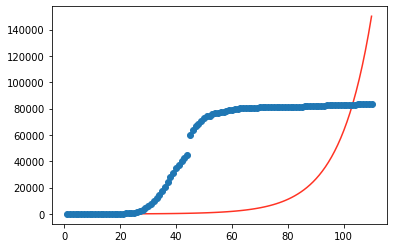

In [36]:
# Parámetros que no cambian

N = 1438328434 # population en China
Ti = 20 # Basado en el paper de Italia, pag 6
gamma = 1/Ti

# Es necesario agarrar los días pero con números y no como strings para meterlos
# como puntos y hacer el curve fitting
xdata = np.arange(1,len(df_CHN['date'])+1,1)

# Para que la función acepte los datos tienen que estar en forma de array
ydata = np.array(df_CHN['total_cases'],dtype=int)

t = np.linspace(1, 110, 100) # días


# Datos iniciales
I0 = df_CHN['total_cases'].iloc[0] # contagiados inicialmente 
S0 = N-I0
R0 = 0
E0 = I0
D0 = 0

y0 = S0, I0, R0, E0, D0

# Hacemos el curve fit de los datos. La función devuelve en popt los parámetros óptimos
popt, pcov = curve_fit(fit_odeint,np.array(xdata),ydata,bounds=([0,0,0],[np.inf,np.inf,np.inf]))

# Resolvemos el sistema de ecuaciones diferenciales 
ret = odeint(SEIRD, y0, t, args=tuple(popt))
# Guardamos las funciones solución de las ED
S, I, R, E, D = ret.T

plt.plot(t,I,color=rojo_cool) # Curva ajustada
plt.plot(xdata, ydata, 'o')   # Datos reales
plt.show()


In [33]:
#